In [35]:
import torch
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
from torch import optim

import numpy as np

#train and test data directory
data_dir = "./Dataset/train"
test_data_dir = "./Dataset/test"


def load_split_train_test(data_dir, test_data_dir):

    #load the train and test data
    train_data = ImageFolder(data_dir,transform = transforms.Compose([
        transforms.Resize((150,150)),transforms.ToTensor()
    ]))
    test_data = ImageFolder(test_data_dir,transforms.Compose([
        transforms.Resize((150,150)),transforms.ToTensor()
    ]))

    trainloader = torch.utils.data.DataLoader(train_data, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=64)
    return trainloader, testloader
    
trainloader, testloader = load_split_train_test(data_dir, test_data_dir, .2)


In [14]:
model = models.resnet50(pretrained=True)
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

In [38]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs, labels
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs, labels
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals =  top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'resnetmodel.pth')

tensor([[[[0.2902, 0.2235, 0.4157,  ..., 0.9882, 0.9882, 0.9882],
          [0.2902, 0.2431, 0.4784,  ..., 0.9882, 0.9882, 0.9882],
          [0.2196, 0.2118, 0.3922,  ..., 0.9882, 0.9882, 0.9882],
          ...,
          [0.3294, 0.2314, 0.2000,  ..., 0.6510, 0.5765, 0.5490],
          [0.3608, 0.2471, 0.2510,  ..., 0.6588, 0.6118, 0.5333],
          [0.3020, 0.2471, 0.3137,  ..., 0.6824, 0.6235, 0.5922]],

         [[0.2863, 0.2235, 0.3843,  ..., 0.9882, 0.9882, 0.9882],
          [0.2784, 0.2314, 0.4353,  ..., 0.9882, 0.9882, 0.9882],
          [0.2078, 0.2039, 0.3647,  ..., 0.9882, 0.9882, 0.9882],
          ...,
          [0.4000, 0.2588, 0.1961,  ..., 0.6314, 0.5647, 0.5255],
          [0.4275, 0.2784, 0.2353,  ..., 0.6392, 0.5961, 0.4902],
          [0.3569, 0.2863, 0.2941,  ..., 0.6627, 0.6118, 0.5490]],

         [[0.3216, 0.2431, 0.4000,  ..., 0.9882, 0.9882, 0.9882],
          [0.3333, 0.2510, 0.4431,  ..., 0.9882, 0.9882, 0.9882],
          [0.2627, 0.2392, 0.3882,  ..., 0

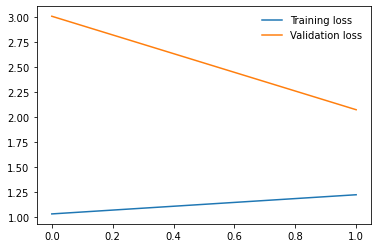

In [39]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [44]:
valid_data_dir =  "./Dataset/val"
valid_transforms = transforms.Compose([transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                     ])
# valid_data = ImageFolder(valid_data_dir,transform = transforms.Compose([
#     transforms.Resize((150,150)),transforms.ToTensor()
# ]))

In [42]:
model=torch.load('resnetmodel.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [65]:
def predict_image(image):
    image_tensor = valid_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    output = model(image_tensor)
    index = output.data.cpu().numpy().argmax()
    return index

In [89]:
def transform_valid_data(valid_data_dir, num=None):
    valid_data = ImageFolder(valid_data_dir,transform = transforms.Compose([
        transforms.Resize((150,150)),transforms.ToTensor()
    ]))
    # Sampling from valid dataset
    indices = list(range(len(valid_data)))
    np.random.shuffle(indices)
    if num:
        idx = indices[:num]
        sampler = SubsetRandomSampler(idx)

        # load data
        loader = torch.utils.data.DataLoader(valid_data, sampler = sampler,  batch_size=num)
    else:
        num = len(indices)
        loader = torch.utils.data.DataLoader(valid_data, batch_size=num)

    classes = loader.dataset.classes
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels, classes

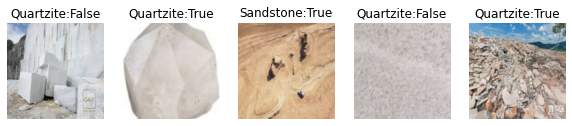

In [92]:
to_pil = transforms.ToPILImage()

images, labels, classes = transform_valid_data(valid_data_dir,5)

fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [99]:
from sklearn.metrics import f1_score

predict_labels = []
true_labels = []

to_pil = transforms.ToPILImage()
images, labels, classes = transform_valid_data(valid_data_dir)
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    true_labels.append(int(labels[ii]))
    predict_labels.append(index)
    
f1_score(true_labels,predict_labels, labels=classes, average='micro')

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


/Users/enjuichang/VSProject/classy-rock/classy_rock/lib/python3.7/site-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''